In [4]:
!pip install -q opendatasets
!pip install -q statsmodels

# Import Libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import opendatasets as od
from warnings import simplefilter
import seaborn as sns
from sklearn.linear_model import LinearRegression

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

## Define functions

In [13]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [7]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# Data Loading

In [10]:
od.download("https://www.kaggle.com/datasets/ryanholbrook/ts-course-data")

100%|██████████| 120k/120k [00:00<00:00, 568kB/s]

In [11]:
tunnel = pd.read_csv("/content/ts-course-data/tunnel.csv", parse_dates=['Day'])
tunnel = tunnel.set_index("Day").to_period("D")

# Data Exploration

<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='NumVehicles'>

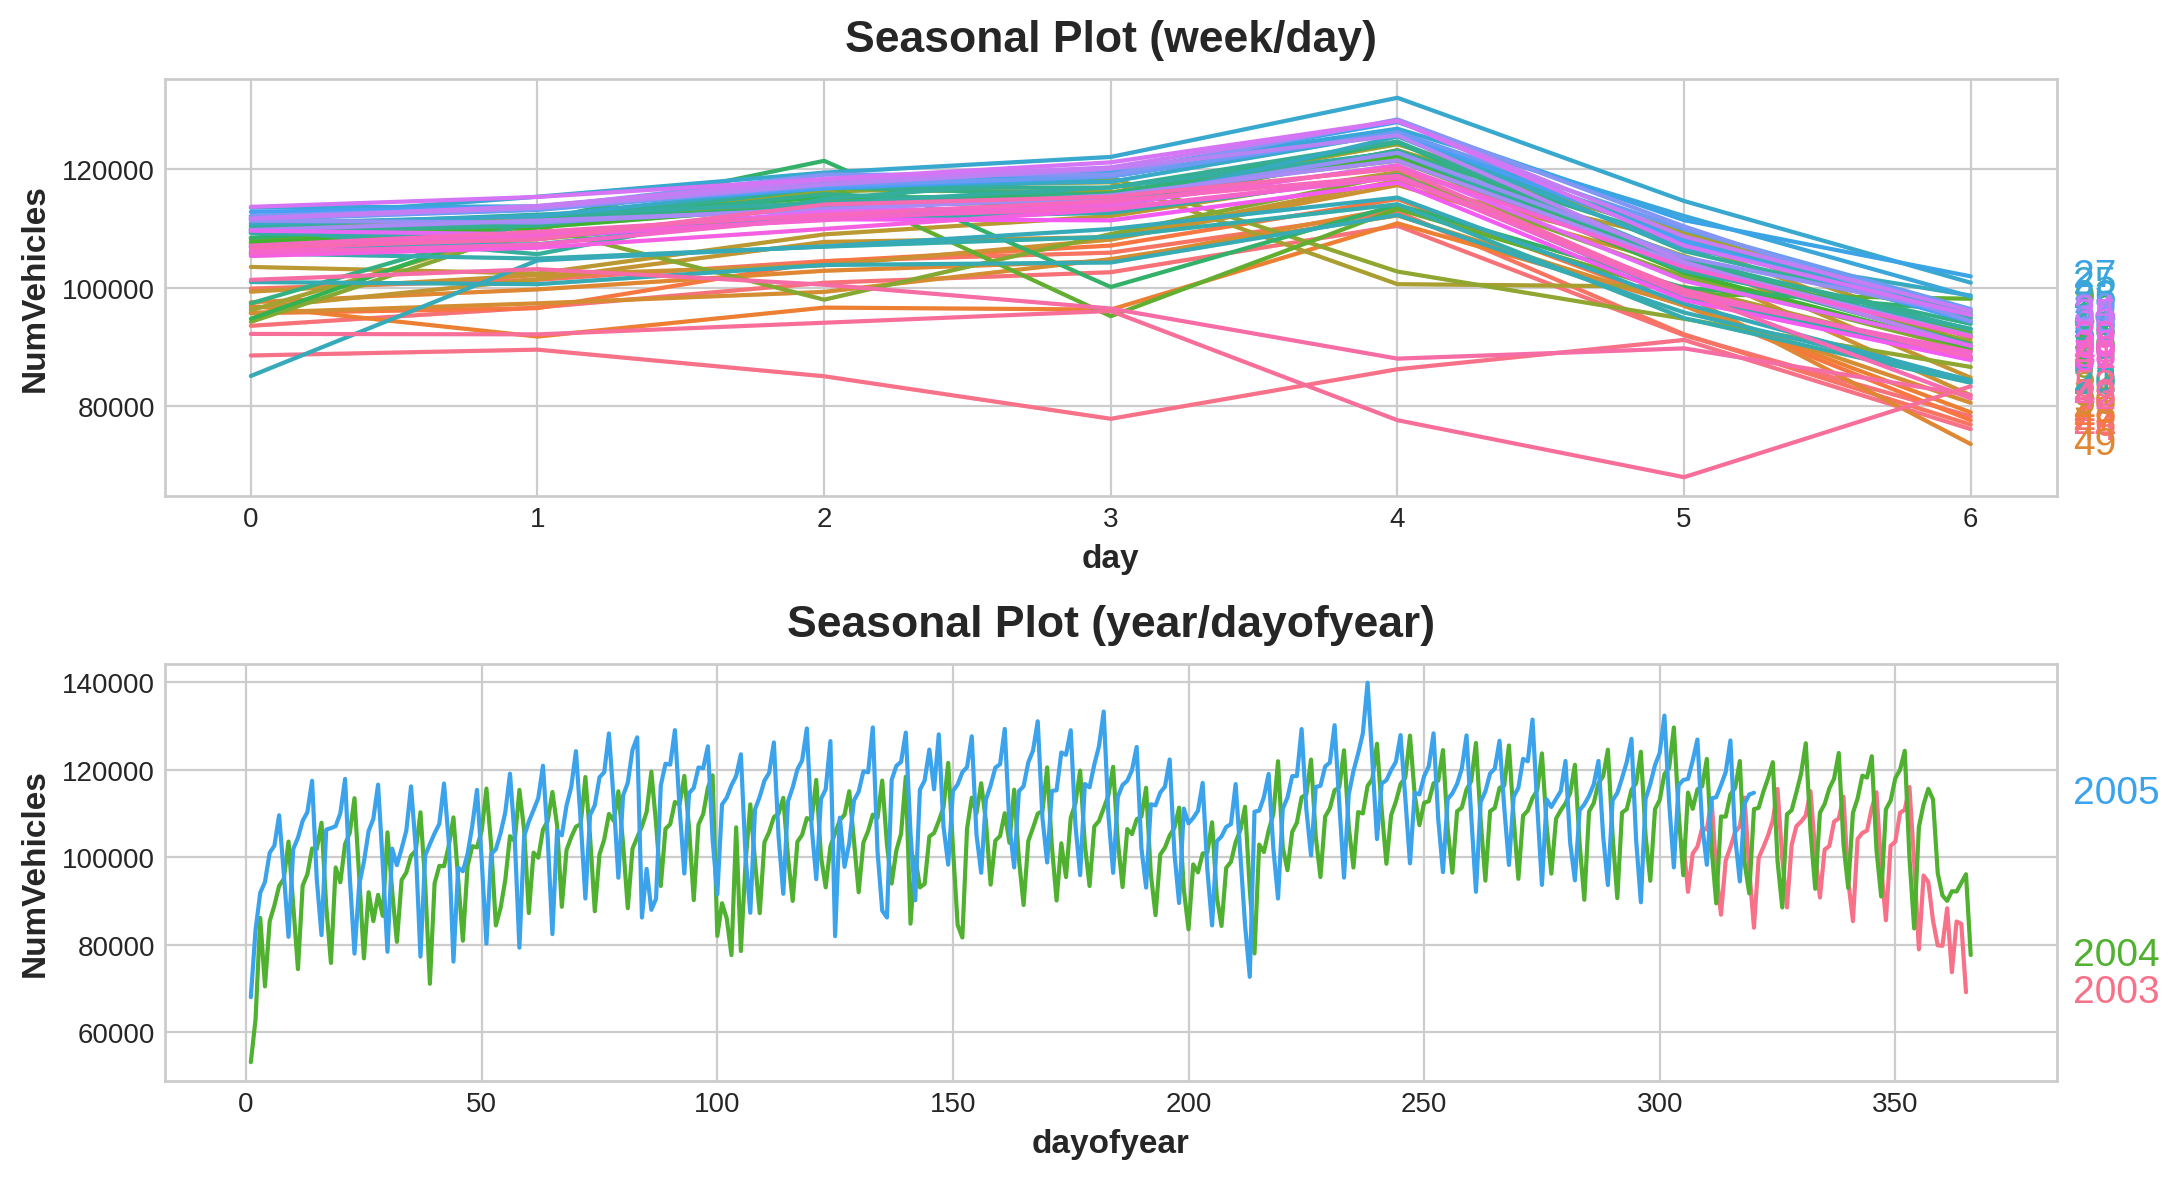

In [14]:
X = tunnel.copy()

# Days within a week
X["day"] = X.index.dayofweek # the x-axis (freq)
X["week"] = X.index.week # the seasonal period (period)

# Days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11,6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

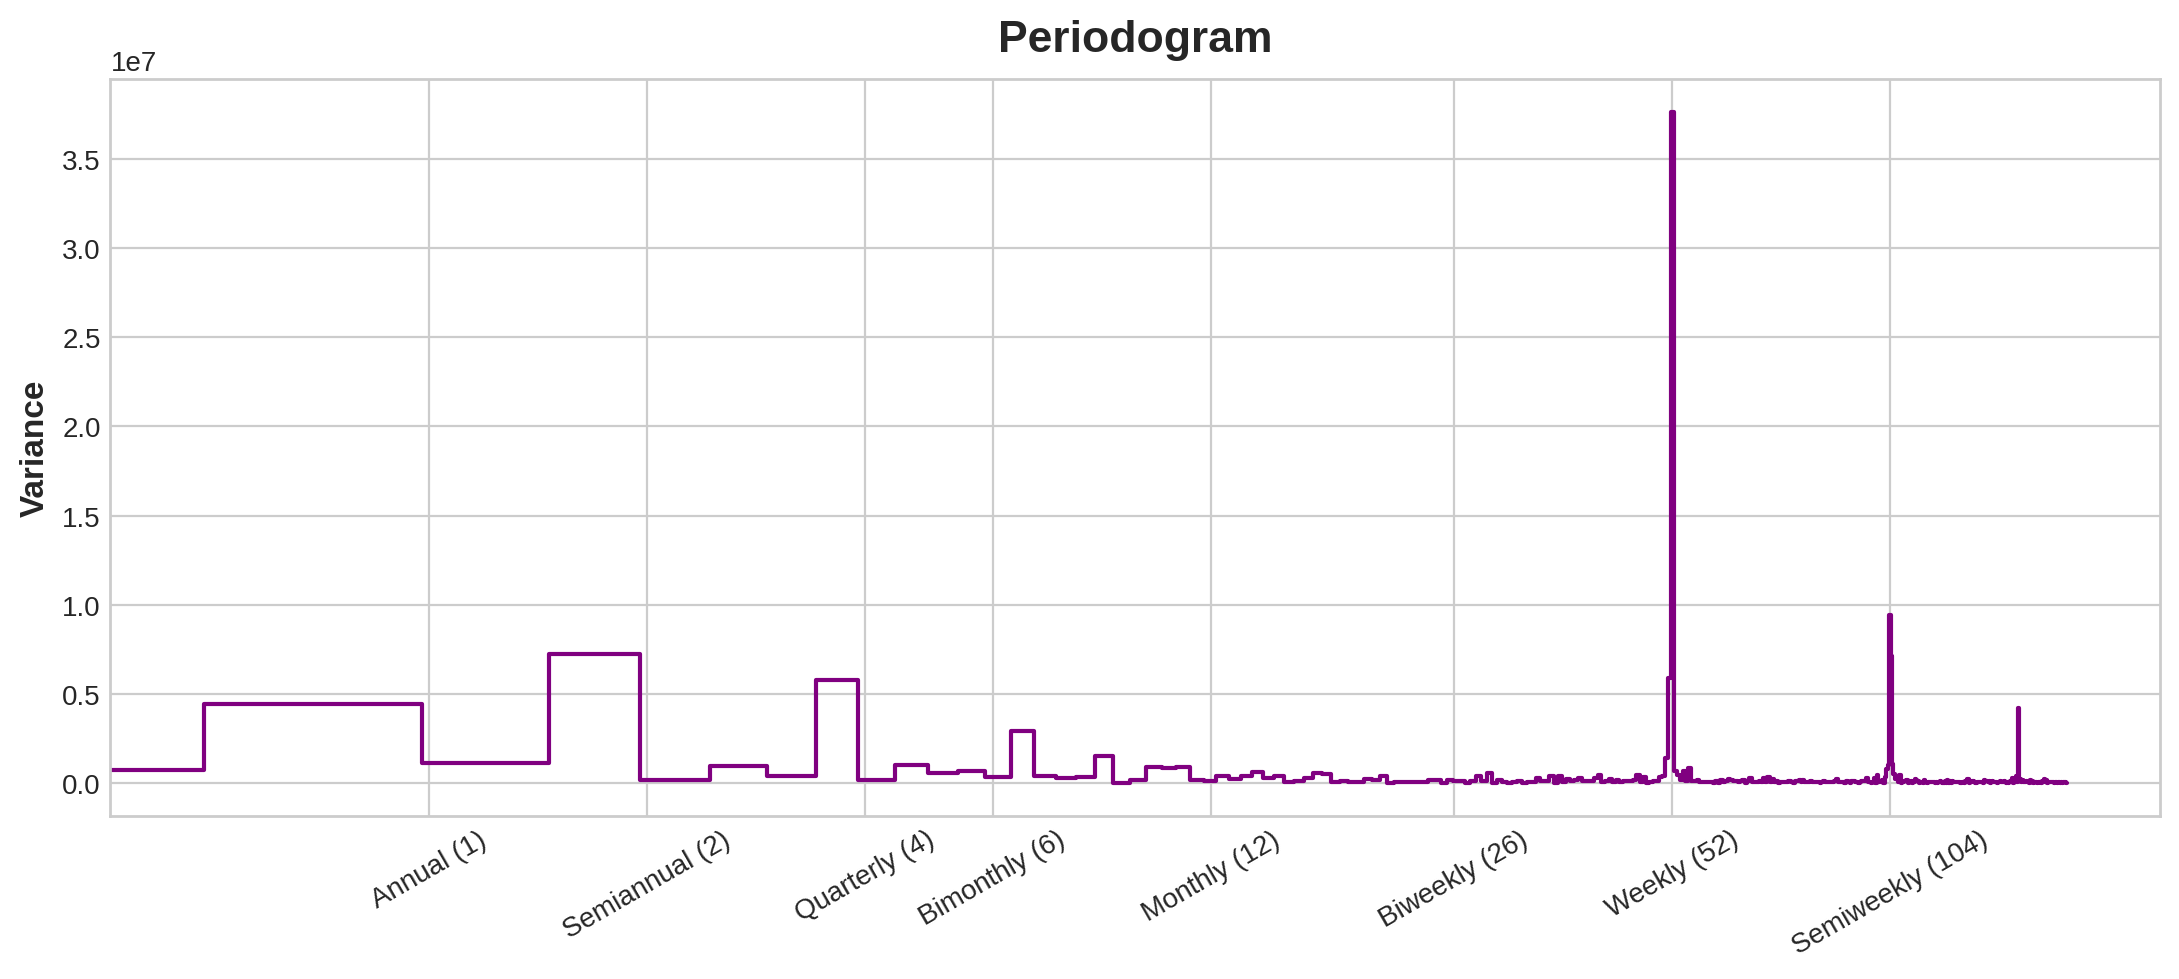

In [15]:
plot_periodogram(tunnel.NumVehicles)

# Data Preparation

In [16]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10) # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()

# Training

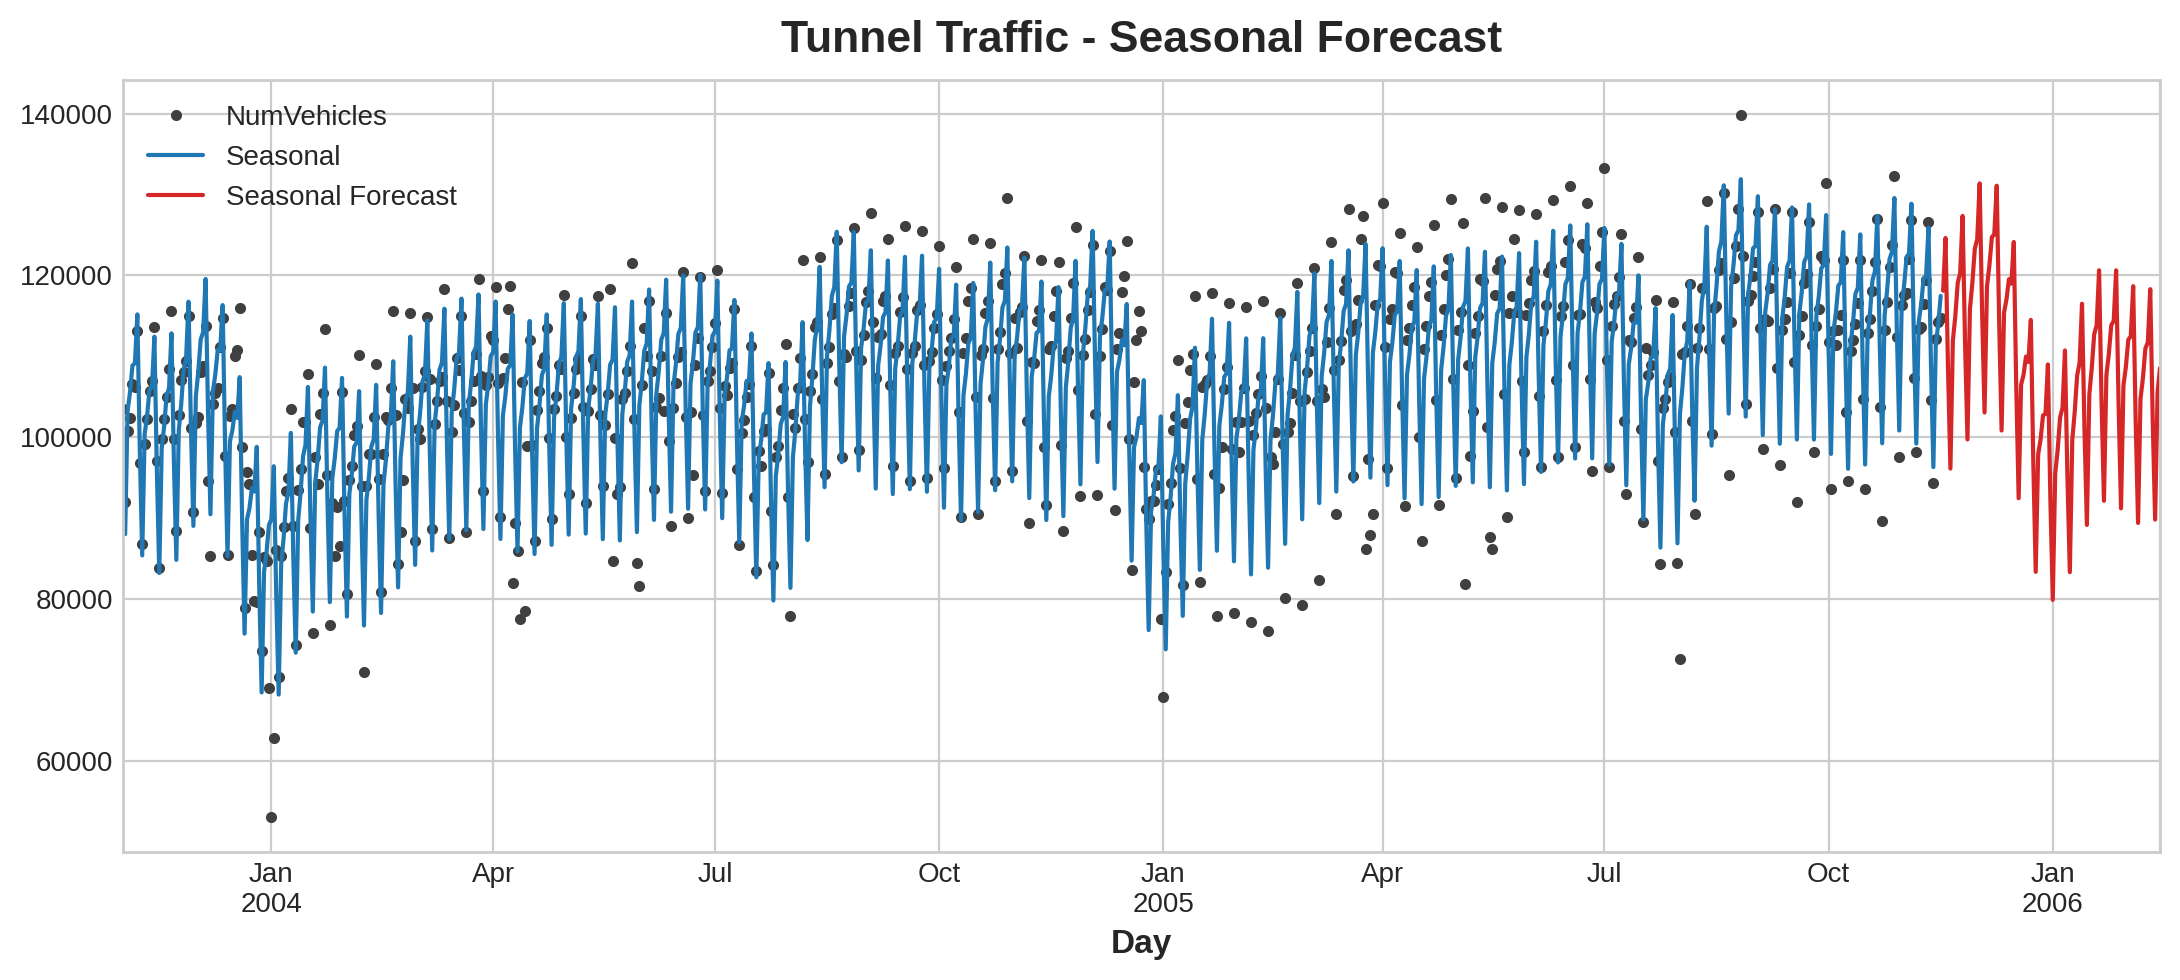

In [18]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color="0.25", style=".", title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color="C3")
_ = ax.legend()